# 0. Obtention des données
Obtention des données à partir du site www.basketball-reference.com et sérialization de la page HTML grâce à la librairie BeautifulSoup


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

#Tableau en constante indiquant les colonnes communes aux datasets des jeux olympiques 
#et de la NBA devant être convertit en format numérique.
colonneNumeriqueCommun = ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

#Tableau en constante indiquant les colonnes numérique qui sont exclusives au dataset de la NBA
colonneNumeriqueNBA = ['Rk', 'Age', 'GS']

#Nous avons besoin de deux méthodes séparées pour les données de la NBA et des jeux olympiques
#puisque les pages HTML ne sont pas encodées de la même façon.
def ObtenirResultatsNBA(year):
    
    #On injecte l'année dans l'URL du site web pour avoir l'année souhaité
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)
    
    #On créer la requête HTTP et on parse le HTML grâce à la librairie BeautifulSoup
    r = requests.get(url)
    r_html = r.text
    soup = BeautifulSoup(r_html,'html.parser')
    
    #On trouve le thead du tableau afin d'obtenir les noms de colonne
    head = soup.find(class_="thead")
    #Nous trouvons l'élément HTML ayant comme class full_table, afin d'obtenir
    #le contenu du tableau
    body = soup.find_all(class_="full_table")
    
    #On nettoie le HTML reçu et on enlève les tags de padding au debut et à la fin
    nomscolonne=[head.text for item in head][0].replace("\n",",").split(",")[1:-1]
    
    joueurs=[]
    
    #On itère dans toutes les lignes de contenu du tableau
    for i in range(len(body)):
        
        joueur = []
        
        #On itère dans toutes les colonnes de la ligne en cours
        #On va chercher toutes les éléments ayant pour tag th ou td. Le rang 
        #th comme tag alors que les autres colonne sont td.
        for td in body[i].find_all(['th', 'td']):
            joueur.append(td.text)
    
        joueurs.append(joueur)
        
    #On créer un nouveau dataframe avec la liste des joueurs et les noms de colonne.
    df = pd.DataFrame(joueurs, columns=nomscolonne).set_index("Player")
    #On nettoie les noms des joueurs des charactères spéciaux pouvant s'y trouver
    df.index = df.index.str.replace('*', '', regex=True)
    
    #Conversion des colonnes numériques
    df[colonneNumeriqueCommun + colonneNumeriqueNBA] = df[colonneNumeriqueCommun + colonneNumeriqueNBA].apply(pd.to_numeric, errors='ignore')

    return df

def ObtenirResultatsJO(year):
    
    #On injecte l'année dans l'URL du site web pour avoir l'année souhaité
    url = 'https://www.basketball-reference.com/international/mens-olympics/{}_per_game.html'.format(year)

    #On créer la requête HTTP et on parse le HTML grâce à la librairie BeautifulSoup
    r = requests.get(url)
    r_html = r.text
    soup = BeautifulSoup(r_html,'html.parser')
    
    #On va trouvé l'élément HTML ayant commme class stats_table
    table = soup.find(class_="stats_table")
    #On cherche l'élément thead à l'intérieur de table afin de trouver les noms de colomne
    head = table.find('thead')
    #On cherche l'élément tbody à l'intérieur de table afin de trouver le contenu
    #du tableau et on créer une liste de tous les éléments tr s'y trouvant afin 
    #de créer un tableau avec les données brutes 
    body = table.find('tbody').find_all('tr')
    
    #On nettoie le HTML reçu et on enlève les tags de padding au debut et à la fin
    nomscolonne = [head.text for item in head][0].replace("\n",",").split(",")[2:-2]
    
    joueurs = []
    
    #On itère dans toutes les lignes de contenu du tableau
    for i in range(len(body)):
        
        joueur = []
        
        #On itère dans toutes les colonnes de la ligne en cours
        #On va chercher toutes les éléments ayant pour tag th ou td. Le nom de joueur a 
        #th comme tag alors que les autres colonne sont td.
        for td in body[i].find_all(['th', 'td']):
            joueur.append(td.text)
    
        joueurs.append(joueur)
        
    #On créer un nouveau dataframe avec la liste des joueurs et les noms de colonne.
    df = pd.DataFrame(joueurs, columns=nomscolonne).set_index("Player")
    #On nettoie les noms des joueurs des charactères spéciaux pouvant s'y trouver
    df.index = df.index.str.replace('*', '', regex=True)
    
    #Conversion des colonnes numériques
    df[colonneNumeriqueCommun] = df[colonneNumeriqueCommun].apply(pd.to_numeric, errors='ignore')

    
    return df

In [3]:
#2016
joueurJO2016 = ObtenirResultatsJO('2016')
joueurNBA2016 = ObtenirResultatsNBA('2016')

#2020
joueurJO2020 = ObtenirResultatsJO('2020')
joueurNBA2020 = ObtenirResultatsNBA('2020')


# 1. Quel est la corrélation entre la participation aux Olympiques et le classements des joueurs dans la NBA?

## 2016

### 1.1.1 - Quel est le rang NBA relatif aux joueurs des équipes Olympique 2016?

In [4]:
#jointure des jeux de données J.O. et NBA 2016, afin de pouvoir identifier les joueurs correspondant à l'intersection des ensembles
#et leur rang respectif à la NBA
joueur2016 = joueurJO2016.join(joueurNBA2016, lsuffix='_JO', rsuffix='_NBA', how='inner').sort_values(by=['Rk'])
joueur2016[['Rk', 'Team']]

,Rk,Team
Player,,
Carmelo Anthony,21,United States
Cameron Bairstow,30,Australia
Leandro Barbosa,31,Brazil
Harrison Barnes,34,United States
Nicolas Batum,38,France
Aron Baynes,40,Australia
Andrew Bogut,54,Australia
Jimmy Butler,72,United States
DeMarcus Cousins,97,United States


### 1.1.2 - Statistiques descriptives du rang NBA des joueurs de léquipe nationale en 2016 / Moyenne du rang NBA de l'équipe Olympique

In [6]:
#std et median utiles?
#sinon : joueur2016_complet.mean()
joueur2016.agg({'Rk':['mean','median','std']})

,Rk
mean,176.566667
median,155.500000
std,119.417749


### 1.1.3 - Distribution des rang NBA selon les équipes nationale 2016

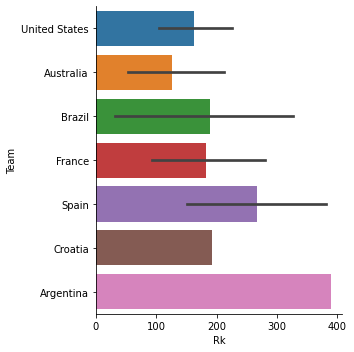

In [7]:
import seaborn
seaborn.catplot(kind='bar',x='Rk',y='Team',data=joueur2016[['Rk', 'Team']])

### 1.1.4 - Degré de similarité de la composition des équipes nationales et du classement des joueurs de la NBA

In [8]:
from nltk.metrics.distance import jaccard_distance
nba_bestset = set(joueurNBA2016.index)
jo_set = set(joueur2016.index)

distance_2016 = jaccard_distance(nba_bestset,jo_set)
similarite_jaccard2016 = 1 - distance_2016
print('Similarité de Jaccard entre les joueurs de la NBA et l\'équipe Olympique en 2016 :{0} '.format(similarite_jaccard2016))

Similarité de Jaccard entre les joueurs de la NBA et l'équipe Olympique en 2016 :0.06302521008403361 


## 2020

### 1.2.1 - Quel est le rang NBA relatif aux joueurs de l'équipe Olympique 2020?

In [10]:
joueur2020 = joueurJO2020.join(joueurNBA2020, lsuffix='_JO', rsuffix='_NBA', how='inner').sort_values(by=['Rk'])
joueur2020[['Rk', 'Team']]

,Rk,Team
Player,,
Bam Adebayo,2,United States
Nicolas Batum,31,France
Aron Baynes,32,Australia
Isaac Bonga,54,Germany
Devin Booker,55,United States
Matthew Dellavedova,127,Australia
Dante Exum,150,Australia
Evan Fournier,159,France
Danilo Gallinari,168,Italy


### 1.2.2 - Statistiques descriptives du rang NBA des joueurs de l'équipe nationale en 2020 / Moyenne du rang NBA de l'équipe Olympique

In [59]:
#On cherche à trouver la moyenne, la médiane et l'écart type du rang des joueurs
joueur2020.agg(
    {'Rk':['mean','median','std']})

,Rk
mean,262.939394
median,259.000000
std,145.636306


### 1.2.3 - Distribution des rang NBA selon les équipes nationales 2020

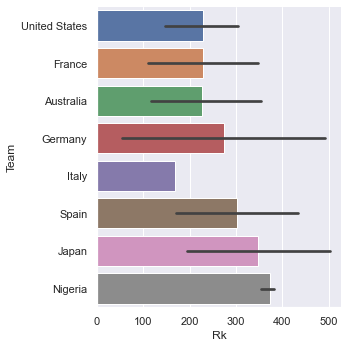

In [60]:
import seaborn
seaborn.catplot(kind='bar',x='Rk',y='Team',data=joueur2020[['Rk', 'Team']])

### 1.2.4 - Degré de similarité de la composition de l'équipe nationale et du classement des joueurs

In [61]:
from nltk.metrics.distance import jaccard_distance
nba_bestset = set(joueurNBA2020.index)
jo_set = set(joueur2020.index)

distance_2020 = jaccard_distance(nba_bestset,jo_set)
similarite_jaccard2020 = 1 - distance_2020
print('Similarité de Jaccard entre les joueurs de la NBA et l\'équipe Olympique en 2020 :{0} '.format(similarite_jaccard2020))

Similarité de Jaccard entre les joueurs de la NBA et l'équipe Olympique en 2020 :0.06238185255198492 


# 2. Est-ce que les joueurs de la NBA ont une performance similaire moyenne en saison régulière comparé aux olympiques (Points, rebound, assist et block)?

In [62]:
#Question 2: 
statsjoueurNBA2020 = joueurNBA2020.agg(  
    {
       "PTS": ['mean'], #Points Per game 
       "TRB": ['mean'], #Rebound per game 
       "AST": ['mean'], #Assists per game 
       "BLK": ['mean'], #Blocks per Game 
    }
)

statsjoueurNBA2020      

,PTS,TRB,AST,BLK
mean,8.726465,3.632703,1.923629,0.399055


In [63]:
statsjoueurJO2020 = joueurJO2020.agg(
 {
       "PTS": ['mean'], #Points Per game 
       "TRB": ['mean'], #Rebound per game 
       "AST": ['mean'], #Assists per game 
       "BLK": ['mean'], #Blocks per Game 
 }
)
statsjoueurJO2020

,PTS,TRB,AST,BLK
mean,7.264336,2.974825,1.717483,0.245455


In [64]:
statsjoueurJO2016 = joueurJO2016.agg(
 {
       "PTS": ['mean'], #Points Per game 
       "TRB": ['mean'], #Rebound per game 
       "AST": ['mean'], #Assists per game 
       "BLK": ['mean'], #Blocks per Game 
 }
)
statsjoueurJO2016

,PTS,TRB,AST,BLK
mean,7.044681,2.824823,1.684397,0.24539


In [65]:
statsjoueurNBA2016 = joueurNBA2016.agg(  
    {
       "PTS": ['mean'], #Points Per game 
       "TRB": ['mean'], #Rebound per game 
       "AST": ['mean'], #Assists per game 
       "BLK": ['mean'], #Blocks per Game     
 }
)
statsjoueurNBA2016

,PTS,TRB,AST,BLK
mean,8.34937,3.620378,1.82605,0.415126


In [66]:
# Calcul de la difference  pour la moyenne des stats des meilleurs joueurs de la NBA et les joeurs des JO 

DifPoints2020 = round((statsjoueurNBA2020['PTS']['mean'] - statsjoueurJO2020['PTS']['mean']),2)
DifAssists2020 = round((statsjoueurNBA2020['AST']['mean'] - statsjoueurJO2020['AST']['mean']),2)
DifBlocks2020 = round((statsjoueurNBA2020['BLK']['mean'] - statsjoueurJO2020['BLK']['mean']),2)
DifRebounds2020 = round((statsjoueurNBA2020['TRB']['mean'] - statsjoueurJO2020['TRB']['mean']),2)

DifPoints2016 = round((statsjoueurNBA2016['PTS']['mean'] - statsjoueurJO2016['PTS']['mean']),2)
DifAssists2016 = round((statsjoueurNBA2016['AST']['mean'] - statsjoueurJO2016['AST']['mean']),2)
DifBlocks2016 = round((statsjoueurNBA2016['BLK']['mean'] - statsjoueurJO2016['BLK']['mean']),2)
DifRebounds2016 = round((statsjoueurNBA2016['TRB']['mean'] - statsjoueurJO2016['TRB']['mean']),2)


#Calculateur des ratios 
RatioPointsPlayer2020 = round((DifPoints2020 / statsjoueurNBA2020['PTS']['mean']) *100, 2)
RatioAssistsPlayer2020 = round((DifAssists2020 / statsjoueurNBA2020['AST']['mean'])*100 ,2)
RatioBlocksPlayer2020 = round((DifBlocks2020 / statsjoueurNBA2020['BLK']['mean']) *100 , 2)
RatioReboundsPlayer2020 = round((DifRebounds2020 / statsjoueurNBA2020['TRB']['mean']) *100 ,2)

RatioPointsPlayer2016 = round((DifPoints2016 / statsjoueurNBA2016['PTS']['mean']) *100,2)
RatioAssistsPlayer2016 = round((DifAssists2016 / statsjoueurNBA2016['AST']['mean']) *100, 2)
RatioBlocksPlayer2016 = round((DifBlocks2016 / statsjoueurNBA2016['BLK']['mean'])*100,2)
RatioReboundsPlayer2016 = round((DifRebounds2016  / statsjoueurNBA2016['TRB']['mean']) *100, 2)


print("En 2020, les joueurs de NBA ont inscrit en moyenne {0} points de plus qu'aux JO soit une difference de {1} %".format(DifPoints2020,RatioPointsPlayer2020 ))
print("En 2016, les joueurs de NBA ont inscrit en moyenne {0} points de plus qu'aux JO soit une difference de {1} %\n".format(DifPoints2016,RatioPointsPlayer2016 ))

print("En 2020, les joueurs de NBA ont réussi en moyenne {0} assistes de plus qu'aux JO soit une difference de {1} %".format(DifAssists2020,RatioAssistsPlayer2020 ))
print("En 2016, les joueurs de NBA ont réussi en moyenne {0} assistes de plus qu'aux JO soit une difference de {1} % \n".format(DifAssists2016,RatioAssistsPlayer2016))

print("En 2020, les joueurs de NBA ont réussi en moyenne {0} block de plus qu'aux JO soit une difference de {1} %".format(DifBlocks2020,RatioBlocksPlayer2020 ))
print("En 2016, les joueurs de NBA ont réussi en moyenne {0} block de plus qu'aux JO soit une difference de {1} % \n".format(DifBlocks2016,RatioBlocksPlayer2016))

print("En 2020, les joueurs de NBA ont réussi en moyenne {0} rebounds de plus qu'aux JO soit une difference de {1} %".format(DifRebounds2020,RatioReboundsPlayer2020 ))
print("En 2016, les joueurs de NBA ont réussi en moyenne {0} rebounds de plus qu'aux JO soit une difference de {1} % \n".format(DifRebounds2016,RatioReboundsPlayer2016))

En 2020, les joueurs de NBA ont inscrit en moyenne 1.46 points de plus qu'aux JO soit une difference de 16.73 %
En 2016, les joueurs de NBA ont inscrit en moyenne 1.3 points de plus qu'aux JO soit une difference de 15.57 %

En 2020, les joueurs de NBA ont réussi en moyenne 0.21 assistes de plus qu'aux JO soit une difference de 10.92 %
En 2016, les joueurs de NBA ont réussi en moyenne 0.14 assistes de plus qu'aux JO soit une difference de 7.67 % 

En 2020, les joueurs de NBA ont réussi en moyenne 0.15 block de plus qu'aux JO soit une difference de 37.59 %
En 2016, les joueurs de NBA ont réussi en moyenne 0.17 block de plus qu'aux JO soit une difference de 40.95 % 

En 2020, les joueurs de NBA ont réussi en moyenne 0.66 rebounds de plus qu'aux JO soit une difference de 18.17 %
En 2016, les joueurs de NBA ont réussi en moyenne 0.8 rebounds de plus qu'aux JO soit une difference de 22.1 % 



# 3. Est-ce que la performance moyenne d'une équipe de la NBA est semblable à une équipe Olympique?

# 4. Est-ce que l'écart-type est similaire entre les joueurs d'une équipe de la NBA et de l'Olympique?

## 4.1 L'ensemble des écart-types des joueurs(NBA ET Olympique)

In [67]:
Ensemble = joueur2016.groupby('Team').agg({#"Team":['Count'],
           "PTS_NBA": "std", #Points Per game NBA
           "TRB_NBA": "std", #Rebound per game NBA
           "AST_NBA": "std", #Assists per game NBA
           "BLK_NBA": "std", #Blocks per Game NBA
           "PTS_JO": "std", #Points Per game JO
           "TRB_JO": "std", #Rebound per game JO
           "AST_JO":"std", #Assists per game JO
           "BLK_JO": "std"}) #Blocks per Game JO

#Étant donné que certaines colonnes contiennent des NaN, la fonction .isnull() permettra de stocker True pour les valeurs NaN
Ensemble = Ensemble[~Ensemble['PTS_NBA'].isnull()]
Ensemble

,PTS_NBA,TRB_NBA,AST_NBA,BLK_NBA,PTS_JO,TRB_JO,AST_JO,BLK_JO
Team,,,,,,,,
Australia,2.374588,2.172019,1.546178,0.608824,5.570189,1.684538,2.361356,0.543139
Brazil,0.984886,0.115470,1.106044,0.057735,3.704052,0.832666,2.500667,0.000000
France,3.383489,3.403674,2.244549,0.840833,2.892231,2.211787,1.920937,0.734847
Spain,4.525483,4.737615,3.252691,1.343503,10.253048,4.313351,0.424264,1.343503
United States,5.241812,3.299438,1.814003,0.638179,4.638639,1.672958,1.321386,0.326018


## 4.2. L'écart type des joueurs de la NBA 2016

In [68]:
#Pour ce faire, nous allons regrouper par 'Team'(les pays) et aggréger les colonnes pour trouver l'écart-type.
Écart_NBA2016 = joueur2016.groupby('Team').agg({#"Team":['Count'],
           "PTS_NBA": "std", #Points Per game NBA
           "TRB_NBA": "std", #Rebound per game NBA
           "AST_NBA": "std", #Assists per game NBA
           "BLK_NBA": "std"}) #Blocks per Game NBA

Écart_NBA2016 = Écart_NBA2016[~Écart_NBA2016['PTS_NBA'].isnull()]
Écart_NBA2016

,PTS_NBA,TRB_NBA,AST_NBA,BLK_NBA
Team,,,,
Australia,2.374588,2.172019,1.546178,0.608824
Brazil,0.984886,0.115470,1.106044,0.057735
France,3.383489,3.403674,2.244549,0.840833
Spain,4.525483,4.737615,3.252691,1.343503
United States,5.241812,3.299438,1.814003,0.638179


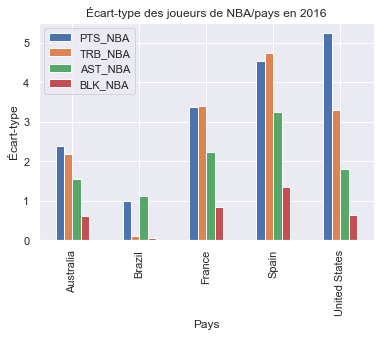

In [69]:
#Nous avons choisi de visualiser les données sous forme d'une diagramme à bandes.
graph_Écart_NBA2016= Écart_NBA2016.plot(kind="bar",title="Écart-type des joueurs de NBA/pays en 2016",xlabel="Pays",ylabel="Écart-type")


## 4.3.L'écart-type des joueurs de l'Olympique en 2016

In [70]:
#Ici,nous utilisons l'abbréviation 'Jo' pour 'Jeux Olympique':
Écart_Olympique2016 = joueur2016.groupby('Team').agg({#"Team":['Count'],
           "PTS_JO": "std", #Points Per game JO
           "TRB_JO": "std", #Rebound per game JO
           "AST_JO":"std", #Assists per game JO
           "BLK_JO": "std"}) #Blocks per Game JO

Écart_Olympique2016 = Écart_Olympique2016[~Écart_Olympique2016['PTS_JO'].isnull()]
Écart_Olympique2016

,PTS_JO,TRB_JO,AST_JO,BLK_JO
Team,,,,
Australia,5.570189,1.684538,2.361356,0.543139
Brazil,3.704052,0.832666,2.500667,0.000000
France,2.892231,2.211787,1.920937,0.734847
Spain,10.253048,4.313351,0.424264,1.343503
United States,4.638639,1.672958,1.321386,0.326018


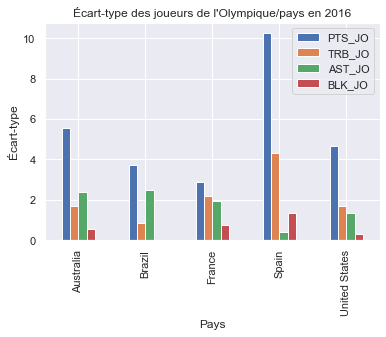

In [71]:
graph_Écart_Olympique2016= Écart_Olympique2016.plot(kind="bar",title="Écart-type des joueurs de l'Olympique/pays en 2016",xlabel="Pays",ylabel="Écart-type")

## 4.4.L'écart-type des joueurs de la NBA 2020

In [72]:
Écart_NBA2020 = joueur2020.groupby('Team').agg({#"Team":['Count'],
           "PTS_NBA": "std", #Points Per game NBA
           "TRB_NBA": "std", #Rebound per game NBA
           "AST_NBA": "std", #Assists per game NBA
           "BLK_NBA": "std"}) #Blocks per Game NBA

Écart_NBA2020 = Écart_NBA2020[~Écart_NBA2020['PTS_NBA'].isnull()]
Écart_NBA2020

,PTS_NBA,TRB_NBA,AST_NBA,BLK_NBA
Team,,,,
Australia,3.854694,1.723659,1.587136,0.263944
France,7.319290,4.890092,1.225561,0.753658
Germany,2.616295,1.060660,0.000000,0.070711
Japan,8.131728,3.535534,1.060660,0.070711
Nigeria,3.202031,1.537856,0.583095,0.207364
Spain,3.889087,1.131371,3.889087,0.494975
United States,7.612745,2.050041,2.367582,0.392853


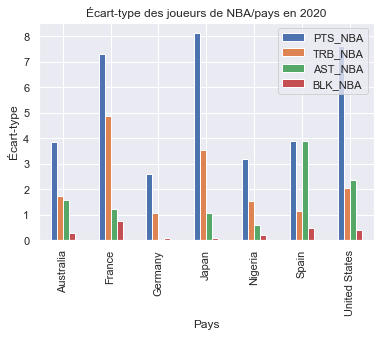

In [73]:
graph_Écart_NBA2020= Écart_NBA2020.plot(kind="bar",title="Écart-type des joueurs de NBA/pays en 2020",xlabel="Pays",ylabel="Écart-type")

## 4.5.L'écart-type des joueurs de l'Olympique en 2020


In [74]:
Écart_Olympique2020 = joueur2020.groupby('Team').agg({#"Team":['Count'],
           "PTS_JO": "std", #Points Per game JO
           "TRB_JO": "std", #Rebound per game JO
           "AST_JO":"std", #Assists per game JO
           "BLK_JO": "std"}) #Blocks per Game JO

Écart_Olympique2020= Écart_Olympique2020[~Écart_Olympique2020 ['PTS_JO'].isnull()]
Écart_Olympique2020 

,PTS_JO,TRB_JO,AST_JO,BLK_JO
Team,,,,
Australia,6.929839,1.502553,1.929767,0.258199
France,6.476496,3.220248,0.973653,0.497996
Germany,2.121320,1.414214,0.848528,0.353553
Japan,3.252691,0.919239,0.000000,0.212132
Nigeria,2.510578,2.247888,0.808084,0.408656
Spain,13.930004,0.565685,1.767767,0.212132
United States,4.765338,1.517344,1.083000,0.503433


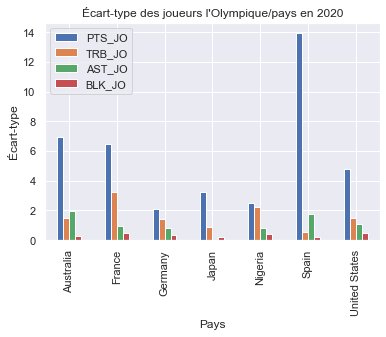

In [75]:
graph_Écart_Olympique2020= Écart_Olympique2020.plot(kind="bar",title="Écart-type des joueurs l'Olympique/pays en 2020",xlabel="Pays",ylabel="Écart-type")